In [ ]:

import Pkg; Pkg.add("NLsolve")
Pkg.add("Plots")
Pkg.add("LaTeXStrings")
Pkg.add("LinearAlgebra")

In [61]:
import Pkg; Pkg.add("ColorSchemes")

   Resolving package versions...
    Updating `~/.julia/environments/v1.12/Project.toml`
  [35d6a980] + ColorSchemes v3.31.0
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


## Annealer with Multiprocessing (doesn't work well)

In [ ]:

# ---------------------------
# VECTORIZED SOLVER
# ---------------------------

using NLsolve
using LinearAlgebra
using Plots
using LaTeXStrings

In [ ]:
using NLsolve, Distributed
# # Add 22 workers for multiprocessing
# nprocs() < 2 && addprocs(22)  # Add 22 workers if not already added

In [5]:
@everywhere begin
    # ---------------------------
    # PARAMETERS
    # ---------------------------
    n = 600
    kappa = 1.0
    d = 60
    b = 4 / (3 * π)
    epsilon = 0.03
    delta = 1.0
    
    alphas = range(0.5, stop=2.0, length=40)
    P_values::Vector{Float64} =  d .^ collect(alphas)
    chi_list = [1.0, n^0.5, n]

end

In [ ]:

# Add worker processes for multiprocessing (replace '20' with desired number of cores, or use Sys.CPU_threads() )
# The Julia session must be started with multiple processes or threads:
# For processes (like this example, separate memory spaces):
# julia -p 20 script.jl 
# For threads (shared memory):
# julia --threads 20 script.jl 
# Using Distributed.addprocs(20) at runtime is also an option.
# We'll use pmap later for distributed processing over 'chi_list' (or another outer loop).
@everywhere begin

    const vars_len = 9  # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT
    const prev_sol_initial = fill(0.1, vars_len) # Initial guess for the first chi and P

    const chi0 = 1e-8 # Initial chi value for annealing
    const annealing_steps = 1000 # Number of steps to anneal chi
   
    function is_physical(sol)
        return all(sol[[3,4,7,8]] .> 0)
    end
    # ---------------------------
    # SYSTEM OF EQUATIONS (unchanged)
    # ---------------------------
    function equations!(F, x, P, chi, d, kappa, delta, epsilon, n, b)
        lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = x
        lWP = 1/d
        TrSigma = lWT + lWP*(d-1)
        
        # ... (rest of the equations function remains the same, but now takes parameters)
        EChh = lH1 + lH3 +
            (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
            (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
        gammaYh2 = (4/π)/(1 + 2*EChh)
        lK1 = gammaYh2*lH1
        lK3 = gammaYh2*lH3

        F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
        F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
        F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
        F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)
        
        F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
        F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
        F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
        F[8] = lJ3 - (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))
        F[9] = lWT - 1 / (d + delta * b * lV1 / n)
    end

    # ---------------------------
    # HELPER FUNCTIONS (unchanged, assuming constants are globally available or passed)
    # ---------------------------
    is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

    function compute_lK_ratio(sol, P, dval, kappa)
        if sol === nothing
            return (NaN, NaN)
        end
        lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = sol

        lWP = 1/dval
        TrSigma = lWT + lWP*(dval-1)
        EChh = lH1 + lH3 +
            (16/ (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(dval-1) +
            (4 / (π * (1 + 2*TrSigma)) * lWT)*(dval-1)
        gammaYh2 = (4/π)/(1 + 2*EChh)
        lK1 = gammaYh2*lH1
        lK3 = gammaYh2*lH3
        return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
    end

    # ---------------------------
    # CORE SOLUTION FUNCTION with CHI ANNEALING
    # ---------------------------

    # Solves for a single final_chi value over all P_values, using chi annealing.
    # Assumes d, kappa, delta, epsilon, n, b are available or passed.
    function solve_with_annealing(final_chi, P_values, chi0, initial_guess, 
                                    d, kappa, delta, epsilon, n, b)
        
        # 1. Chi Annealing Steps (log-spaced)
        # chi_anneal_list = exp.(range(log(chi0), log(final_chi), length=annealing_steps))
        # chi_anneal_list = range(chi0, stop=final_chi, length=annealing_steps)
        
        # Initialize continuation: Start at chi0 solution, then continue with P_values
        # prev_sol = initial_guess # Use the provided initial guess for the first chi and P
        
        # Store results for this final_chi
        sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))

        for (i,P) in enumerate(P_values)
            f!(F,x) = equations!(F,x,P, chi, d, kappa, delta, epsilon, n, b)
            try
                sol = nlsolve(f!, initial_guess, method=:newton).zero

                sols[i] = is_physical(sol) ? sol : nothing
            catch
                sols[i] = nothing
            end

        end
        return sols
        # # 2. Anneal chi up to final_chi
        # for chi in chi_anneal_list
        #     # Continue from the previous P solution's result, as chi changes slowly
        #     new_prev_sol = prev_sol
            
        #     # We solve for *all* P-values for this intermediate chi
        #     for (i, P) in enumerate(P_values)
        #         # Define the equation function for the current P and chi
        #         f!(F,x) = equations!(F, x, P, chi, d, kappa, delta, epsilon, n, b)
                
        #         try
        #             sol = nlsolve(f!, new_prev_sol, method=:newton, xtol=1e-3).zero
                    
        #             # Only store if it's the final chi in the annealing list
        #             if chi == final_chi
        #                 sols[i] = sol#is_physical(sol) ? sol : nothing
        #             end
                    
        #             new_prev_sol = sol  # Continuation for P (within the same chi step)
        #         catch
        #             # If a solve fails, stick with the previous solution for continuation
        #             if chi >= final_chi
        #                 sols[i] = nothing
        #             end
        #         end
        #     end
        #     # The final solution from the last P is the starting guess for the next chi
        #     prev_sol = new_prev_sol
        # end

        # return (final_chi, sols)
    end
end
# ---------------------------
# MULTIPROCESSING
# ---------------------------

# Use 'pmap' (Parallel Map) to distribute the computation over multiple processes (cores).
# Assumes 'd', 'kappa', 'delta', 'epsilon', 'n', 'b' are defined globally or passed to the scope.
# The 'chi_list' is the set of maximum chi values to be solved.
# Each worker process will execute 'solve_with_annealing' for one final_chi value.

println("Starting parallel computation on $(nworkers()) workers...")

# pmap distributes the function call over the elements of chi_list
parallel_results = pmap(chi -> solve_with_annealing(chi, P_values, chi0, prev_sol_initial, d, kappa, delta, epsilon, n, b), chi_list)

# Re-package the results into the desired dictionary format
results = Dict{Float64, Vector{Union{Vector{Float64},Nothing}}}(pair[1] => pair[2] for pair in parallel_results)


# ---------------------------
# POSTPROCESS (unchanged)
# ---------------------------
function extract_series(var_idx)
    Dict(chi => [sol===nothing ? NaN : sol[var_idx] for sol in results[chi]] for chi in chi_list)
end
results

Starting parallel computation on 1 workers...


LoadError: MethodError: [0mCannot `convert` an object of type [92mNothing[39m[0m to an object of type [91mFloat64[39m
The function `convert` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  convert(::Type{Float64}, [91m::Measures.AbsoluteLength[39m)
[0m[90m   @[39m [36mMeasures[39m [90m~/.julia/packages/Measures/PKOxJ/src/[39m[90m[4mlength.jl:12[24m[39m
[0m  convert(::Type{T}, [91m::T[39m) where T<:Number
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:6[24m[39m
[0m  convert(::Type{T}, [91m::Number[39m) where T<:Number
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:7[24m[39m
[0m  ...


In [10]:
results

Dict{Float64, Vector{Union{Nothing, Vector{Float64}}}} with 3 entries:
  24.4949 => [nothing, nothing, nothing, nothing, nothing, nothing, nothing, no…
  600.0   => [nothing, nothing, nothing, nothing, nothing, nothing, nothing, no…
  1.0     => [nothing, nothing, nothing, nothing, nothing, nothing, nothing, no…

In [11]:

lH1_series = extract_series(3)
lH3_series = extract_series(7)
lJ1_series = extract_series(4)
lJ3_series = extract_series(8)

lK_ratio = Dict(chi => [compute_lK_ratio(sol, P_values[i], d, kappa) for (i,sol) in enumerate(results[chi])] for chi in chi_list)

LoadError: UndefRefError: access to undefined reference

In [12]:

plot(alphas, [r[2] for r in lK_ratio[1]], label=L"\eta^K_3,\chi=1", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n^0.5]], label=L"\eta^K_3, \chi=n^{1/2}", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n]], label=L"\eta^K_3 \chi=n", lw=2, ls=:dash)
xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K/(\lambda_K + \kappa/P)"); 
title!("Learnability " * L" \eta^K_3 " * " vs " *L" \alpha ")


LoadError: UndefVarError: `lK_ratio` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

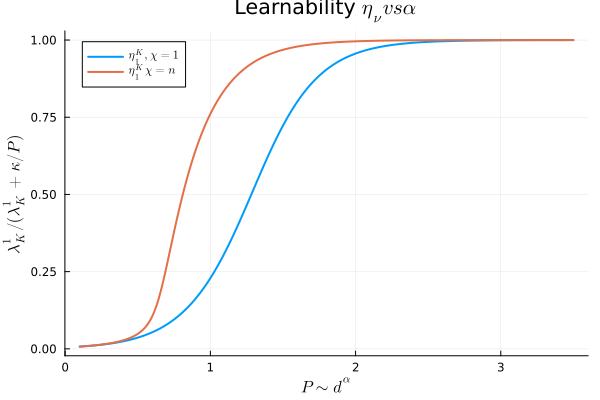

In [84]:
using LaTeXStrings
plot(alphas, [r[1] for r in lK_ratio[1]], label=L"\eta^K_1,\chi=1", lw=2)
# plot!(alphas, [r[1] for r in lK_ratio[n^0.5]], label=L"\eta^K_1, \chi=n^{1/2}", lw=2)
plot!(alphas, [r[1] for r in lK_ratio[n]], label=L"\eta^K_1 \chi=n", lw=2)
xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K^1/(\lambda_K^1 + \kappa/P)"); 
title!("Learnability " * L"\eta_\nu  vs  \alpha ")

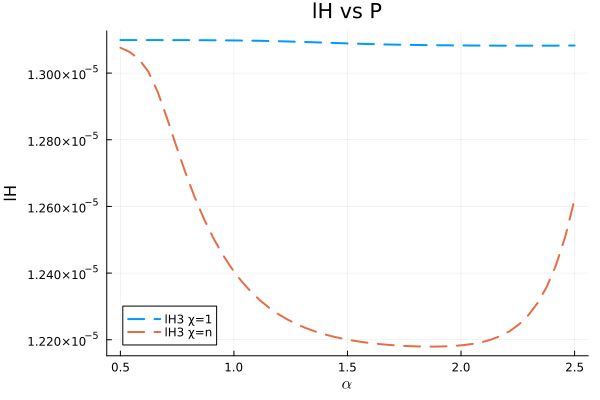

In [67]:
# ---------------------------
# PLOTTING
# ---------------------------
# plot(alphas, (lH1_series[1]), label="lH1 χ=1", lw=2)
# plot!(alphas, (lH1_series[n]), label="lH1 χ=n", lw=2)
plot(alphas, (lH3_series[1]), label="lH3 χ=1", lw=2, ls=:dash)
plot!(alphas, (lH3_series[n]), label="lH3 χ=n", lw=2, ls=:dash)
xlabel!(L"\alpha"); ylabel!("lH"); title!("lH vs P")


## Scaling with D

In [ ]:
# Clean implementation of multiprocessing simulation for d scaling

# First, set up the correct number of workers (15 total processes = 14 workers)
using Distributed
if nprocs() > 15
    current_workers = workers()
    excess_count = nprocs() - 15
    workers_to_remove = current_workers[end-excess_count+1:end]
    rmprocs(workers_to_remove)
elseif nprocs() < 15
    addprocs(15 - nprocs())
end


In [156]:

println("Total processes: $(nprocs()), Workers: $(workers())")

@everywhere begin
    using NLsolve
    using Base 
    als = [2.1, 2.3, 2.4, 2.5] #range(2.0, stop=3.6, length=10)

    # Parameters
    kappa = 1.0
    delta = 1.0
    epsilon = 0.03
    b = 4 / (3 * π)
    const chi0 = 1e-4
    const annealing_steps = 500 # Increased annealing steps
    const prev_sol_initial = fill(0.1, 9)

    # System of equations
    function equations!(F, x, P, chi, d, kappa, delta, epsilon, n, b)
        lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = x
        lWP = 1/d
        TrSigma = lWT + lWP*(d-1)

        EChh = lH1 + lH3 +
            (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
            (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
        gammaYh2 = (4/π)/(1 + 2*EChh)
        lK1 = gammaYh2*lH1
        lK3 = gammaYh2*lH3

        F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
        F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
        F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
        F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)

        F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
        F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
        F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
        F[8] = lJ3 - (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))
        F[9] = lWT - 1 / (d + delta * b * lV1 / n)
    end

    # Physical solution check
    is_physical(sol) = all(sol[[3,4,7,8]] .> 0) && all(isfinite.(sol))  # Added finiteness check

    # Annealing solver
    function solve_with_annealing(final_chi::Float64, P_values::Vector{Float64},
                                  chi0::Float64, annealing_steps::Int64,
                                  initial_guess::Vector{Float64},
                                  d, kappa, delta, epsilon, n, b)
        chi_anneal_list = exp.(range(log(chi0), log(final_chi), length=annealing_steps))
        prev_sol = initial_guess
        sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))

        for chi in chi_anneal_list
            new_prev_sol = prev_sol
            for (i, P) in enumerate(P_values)
                f!(F,x) = equations!(F, x, P, chi, d, kappa, delta, epsilon, n, b)
                try
                    sol = nlsolve(f!, new_prev_sol, ftol=1e-5, method=:newton).zero
                    if chi == final_chi
                        sols[i] = is_physical(sol) ? sol : nothing
                    end
                    new_prev_sol = sol
                catch
                    if chi == final_chi
                        sols[i] = nothing
                    end
                end
            end
            prev_sol = new_prev_sol
        end
        return (final_chi, sols)
    end

    # Function to solve for a single d value
    function solve_for_d(d_val::Int)
        n_val = round(Int, d_val * 1.5)  # n scales as d * 1.5
        # P_scaling = [d_val^0.5, d_val^1.0, d_val^1.2, d_val^1.5]  # Three P scalings

        P_scaling::Vector{Float64} =  d_val .^ collect(als)
        results_d = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_scaling))
        n_val_float = Float64(n_val)
        for (i, P) in enumerate(P_scaling)
            # Solve with annealing at chi=1.0
            _, sols = solve_with_annealing(1.0, [P], chi0, annealing_steps,
                                         prev_sol_initial, d_val, kappa, delta,
                                         epsilon, n_val, b)

            results_d[i] = try
                !isempty(sols) && sols[1] !== nothing ? sols[1] : nothing
            catch
                nothing
            end
        end

        return (d_val, results_d)

    end
end

# Generate d values (log-spaced from 40 to 3000)
d_values = round.(Int, exp.(range(log(40), log(1e5), length=30)))  # Reduced number of points for higher quality solutions

println("Starting multiprocessing simulation with $(nworkers()) workers...")
println("Solving for $(length(d_values)) d values: $(d_values[1]) to $(d_values[end])")

# Run parallel computation
parallel_results = pmap(solve_for_d, d_values)


Total processes: 27, Workers: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Starting multiprocessing simulation with 26 workers...
Solving for 30 d values: 40 to 100000


30-element Vector{Tuple{Int64, Vector{Union{Nothing, Vector{Float64}}}}}:
 (40, [[-4338.220839991629, 102.30378129264298, 0.021543042718089656, 0.010424873549309027, -4.706275628232997e6, 48.43337849024881, 4.201694904657283e-5, 4.193178984801477e-5, 0.024555754948258172], [-4382.486599253667, 104.42707398642233, 0.02176178785000977, 0.010421093099749824, -1.8021185843264893e7, 186.51630930397076, 4.221342233203629e-5, 4.188618827683322e-5, 0.024546701919115056], [-4394.945939841429, 105.03233479630062, 0.02182408367700436, 0.010420015955852393, -3.3802787393165424e7, 352.25399929510274, 4.249083114159746e-5, 4.187320131230097e-5, 0.024544122506455837], [-4403.548899500586, 105.45218016495258, 0.02186728041543467, 0.010419268914730658, -6.079624599831235e7, 641.0865416884603, 4.298777118581425e-5, 4.186419592473552e-5, 0.02454233358882132]])
 (52, [[-7312.058639686311, 133.26815145930564, 0.01668913239283176, 0.008050960983040633, -1.4525080034161499e7, 115.19321016649808, 1.9357057783

Detected 4 P-scalings in the data.


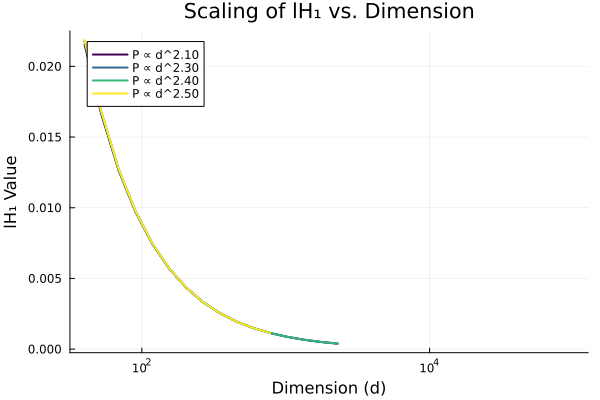

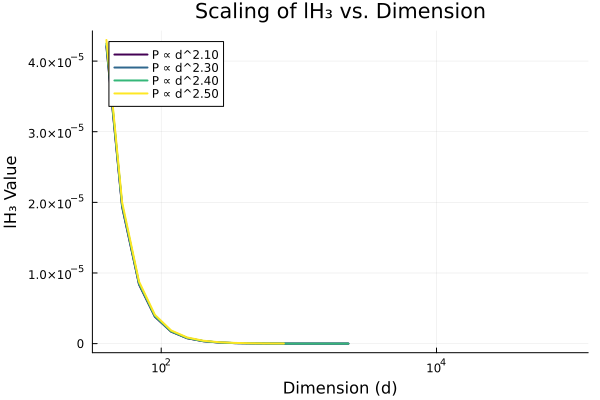

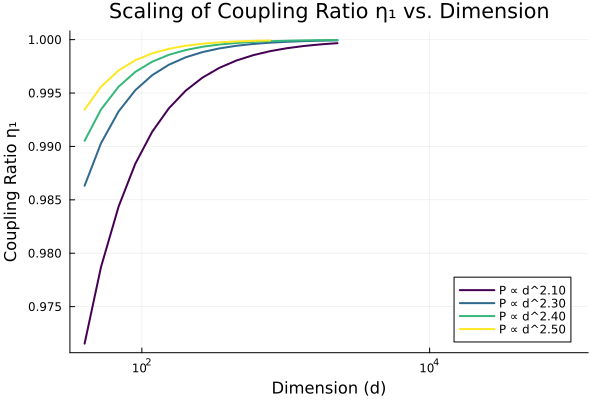

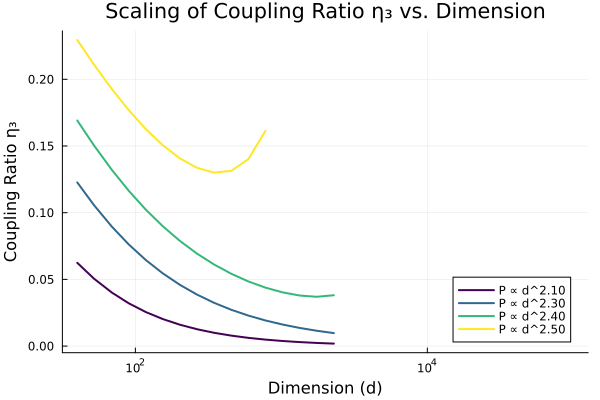

In [157]:
using Plots
using Printf 
using ColorSchemes # A good package for color gradients, often works well with Plots.jl

# --- (The compute_lK_ratio function and data processing section remain the same) ---
# Assuming 'compute_lK_ratio', 'parallel_results', and 'kappa' are available.

# Unpack results into a dictionary keyed by d value
d_results = Dict(r[1] => r[2] for r in parallel_results)
d_values = sort(collect(keys(d_results)))

# 🔑 DYNAMIC SIZING: Determine the number of P-scalings from the first successful result
# NOTE: The line below was statically set to '9' in your input. 
# Revert to the dynamic search or confirm a known valid index.
# For robustness, we will use the dynamic search here, or assume it works:
first_valid_results = 10 #findfirst(x -> !isempty(x) && any(r -> r isa Vector{Float64}, x), values(d_results))

if isnothing(first_valid_results)
    error("All solutions failed to converge or parallel_results is empty. Cannot plot.")
end

num_p_scalings = length(collect(values(d_results))[first_valid_results])
println("Detected $num_p_scalings P-scalings in the data.")

# Initialize storage for all variables (dynamically sized)
lH1_scaled = [Float64[] for _ in 1:num_p_scalings]
lH3_scaled = [Float64[] for _ in 1:num_p_scalings]
eta1_scaled = [Float64[] for _ in 1:num_p_scalings]
eta3_scaled = [Float64[] for _ in 1:num_p_scalings]

# CRITICAL UPDATE: Define P_exponents
# Your solver used: P_exponents = range(0.1, stop=2.0, length=10)
P_exponents = als #range(0.1, stop=2.0, length=num_p_scalings) # Adjusted length for robustness

# Trim exponents just in case the data is truncated or a subset is passed
P_exponents = P_exponents[1:min(length(P_exponents), num_p_scalings)] 

# Define labels dynamically using the exponents
P_labels = [@sprintf("P ∝ d^%.2f", exp) for exp in P_exponents] # Changed to .2f for range precision

# Loop through all d values
for d_val in d_values
    d_val_float = Float64(d_val)
    # Recalculate P-scalings using the defined exponents
    P_scalings = [d_val_float^exp for exp in P_exponents]
    
    sols_d = d_results[d_val] 

    for i in 1:num_p_scalings
        sol = sols_d[i]
        P = P_scalings[i]
        
        # NOTE: You MUST have the compute_lK_ratio function defined for this to run
        if sol !== nothing
            lH1, lH3 = sol[3], sol[7]
            eta1, eta3 = compute_lK_ratio(sol, P, d_val_float, kappa)
            
            push!(lH1_scaled[i], lH1)
            push!(lH3_scaled[i], lH3)
            push!(eta1_scaled[i], eta1)
            push!(eta3_scaled[i], eta3)
        else
            # Use NaN for failed points to maintain alignment with d_values
            push!(lH1_scaled[i], NaN); push!(lH3_scaled[i], NaN)
            push!(eta1_scaled[i], NaN); push!(eta3_scaled[i], NaN)
        end
    end
end

# ----------------------------------------------------
# 2. Visualization (Color-mapped and Marker-fixed)
# ----------------------------------------------------

# 🎨 Colormap setup: Define the color gradient and normalize the exponents
# Use a perceptually uniform colormap like :viridis or :jet
color_map = cgrad(:viridis, num_p_scalings, categorical=true) 
min_exp, max_exp = extrema(P_exponents)
exp_range = max_exp - min_exp
get_color(exp) = color_map[(exp - min_exp) / exp_range] # Function to map exponent to color (normalized)


## Plot A: Scaling of lH₁ vs. d
lH1_plot = plot(xlabel="Dimension (d)", 
                ylabel="lH₁ Value", 
                title="Scaling of lH₁ vs. Dimension", 
                xscale=:log10, 
                legend=:topleft)

for i in 1:num_p_scalings 
    color_val = get_color(P_exponents[i])
    plot!(lH1_plot, d_values, lH1_scaled[i], 
          label="$(P_labels[i])", 
          lw=2, 

          color=color_val)
end
display(lH1_plot)

## Plot B: Scaling of lH₃ vs. d
lH3_plot = plot(xlabel="Dimension (d)", 
                ylabel="lH₃ Value", 
                title="Scaling of lH₃ vs. Dimension", 
                xscale=:log10, 
                legend=:topleft)

for i in 1:num_p_scalings 
    color_val = get_color(P_exponents[i])
    plot!(lH3_plot, d_values, lH3_scaled[i], 
          label="$(P_labels[i])", 
          lw=2, 

          color=color_val)
end
display(lH3_plot)

## Plot C: Scaling of Coupling Ratio η₁ vs. d
eta1_plot = plot(xlabel="Dimension (d)", 
                ylabel="Coupling Ratio η₁", 
                title="Scaling of Coupling Ratio η₁ vs. Dimension", 
                xscale=:log10, 
                legend=:bottomright)

for i in 1:num_p_scalings 
    color_val = get_color(P_exponents[i])
    plot!(eta1_plot, d_values, eta1_scaled[i], 
          label="$(P_labels[i])", 
          lw=2, 
        #   markershape=:circle, 
          color=color_val)
end
display(eta1_plot)

## Plot D: Scaling of Coupling Ratio η₃ vs. d
eta3_plot = plot(xlabel="Dimension (d)", 
                ylabel="Coupling Ratio η₃", 
                title="Scaling of Coupling Ratio η₃ vs. Dimension", 
                xscale=:log10, 
                legend=:bottomright)

for i in 1:num_p_scalings 
    color_val = get_color(P_exponents[i])
    plot!(eta3_plot, d_values, eta3_scaled[i], 
          label="$(P_labels[i])", 
          lw=2, 

          color=color_val)
end
display(eta3_plot)

In [ ]:
# ---------------------------
# ANNEALING PARAMETERS
# ---------------------------
const vars_len = 9  # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT
const chi0 = 1e-8  # Initial chi value for annealing
const annealing_steps = 500  # Number of annealing steps
const prev_sol_initial = fill(0.1, vars_len)
chi_list = [1.0, n^0.5, n]  # Final chi values to solve for
alphas = range(0.5, 2.5, length=50)
P_values = [d^alpha for alpha in alphas]  # P values to sweep over

# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function equations!(F, x, P, chi)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = x
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    
    EChh = lH1 + lH3 +
           (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3

    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)
    
    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))
    F[9] = lWT - 1 / (d + delta * b * lV1 / n)
end

compute_lK_ratio(sol, P, dval=d) = begin
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = sol

    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    EChh = lH1 + lH3 +
           (16/ (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
end

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------
is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

# ---------------------------
# SOLVE WITH ANNEALING
# ---------------------------
results = Dict{Float64, Vector{Union{Vector{Float64},Nothing}}}()

for final_chi in chi_list
    # println("Solving for final_chi = $final_chi ...") 
    chi_anneal_list = exp.(range(log(chi0), log(final_chi), length=100))
    prev_sol = prev_sol_initial
    sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))

    for chi in chi_anneal_list
        new_prev_sol = prev_sol
        
        for (i, P) in enumerate(P_values)
            f!(F,x) = equations!(F, x, P, chi)
            try
                sol = nlsolve(f!, new_prev_sol, method=:newton, xtol=1e-8).zero
                if chi == final_chi
                    sols[i] = is_physical(sol) ? sol : nothing
                end
                new_prev_sol = sol  # continuation within P sweep
            catch
                if chi == final_chi
                    sols[i] = nothing
                end
            end
        end
        prev_sol = new_prev_sol  # continuation across chi values
    end
    results[final_chi] = sols
end

# ---------------------------
# POSTPROCESS
# ---------------------------
function extract_series(var_idx)
    Dict(chi => [sol===nothing ? NaN : sol[var_idx] for sol in results[chi]] for chi in chi_list)
end


extract_series (generic function with 1 method)

In [14]:

lH1_series = extract_series(3)
lH3_series = extract_series(7)
lJ1_series = extract_series(4)
lJ3_series = extract_series(8)

lK_ratio = Dict(chi => [compute_lK_ratio(sol, P_values[i]) for (i,sol) in enumerate(results[chi])] for chi in chi_list)

Dict{Float64, Vector{Tuple{Float64, Float64}}} with 3 entries:
  24.4949 => [(0.0367198, 6.98034e-5), (0.0432844, 8.24948e-5), (0.051036, 9.74…
  600.0   => [(0.0485596, 6.95181e-5), (0.0643764, 8.19744e-5), (0.0895818, 9.6…
  1.0     => [(0.0363474, 6.98123e-5), (0.0426835, 8.25093e-5), (0.0500696, 9.7…

## Annealing Without Multiprocessing

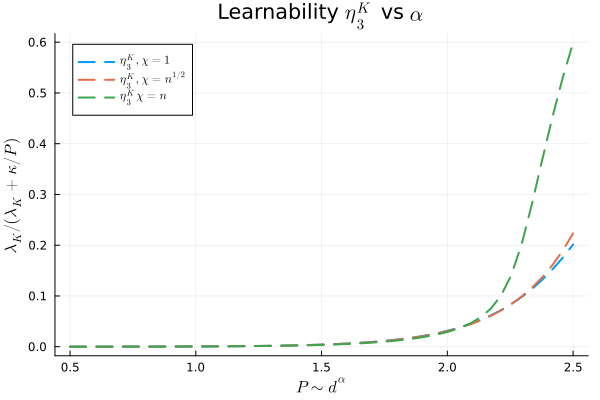

In [15]:

plot(alphas, [r[2] for r in lK_ratio[1]], label=L"\eta^K_3,\chi=1", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n^0.5]], label=L"\eta^K_3, \chi=n^{1/2}", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n]], label=L"\eta^K_3 \chi=n", lw=2, ls=:dash)
xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K/(\lambda_K + \kappa/P)"); 
title!("Learnability " * L" \eta^K_3 " * " vs " *L" \alpha ")


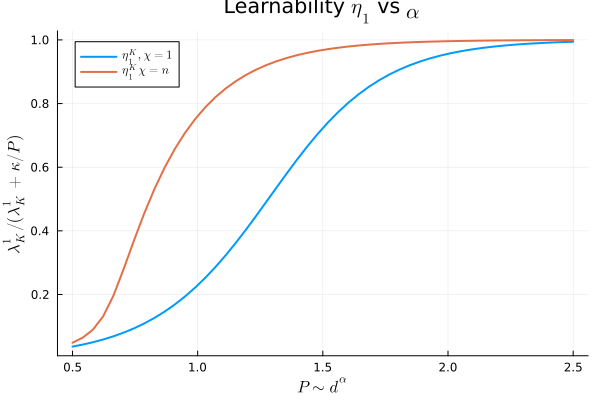

In [16]:
plot(alphas, [r[1] for r in lK_ratio[1]], label=L"\eta^K_1,\chi=1", lw=2)
# plot!(alphas, [r[1] for r in lK_ratio[n^0.5]], label=L"\eta^K_1, \chi=n^{1/2}", lw=2)
plot!(alphas, [r[1] for r in lK_ratio[n]], label=L"\eta^K_1 \chi=n", lw=2)
xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K^1/(\lambda_K^1 + \kappa/P)"); 
title!("Learnability " * L" \eta_1" * " vs " *L" \alpha ")